# Automatically generating object masks with SAM

_**Modified from `notebooks/automatic_mask_generator_example.ipynb`**_

Since SAM 2 can efficiently process prompts, masks for the entire image can be generated by sampling a large number of prompts over an image.

The class `SAM2AutomaticMaskGenerator` implements this capability. It works by sampling single-point input prompts in a grid over the image, from each of which SAM can predict multiple masks. Then, masks are filtered for quality and deduplicated using non-maximal suppression. Additional options allow for further improvement of mask quality and quantity, such as running prediction on multiple crops of the image or postprocessing masks to remove small disconnected regions and holes.

## Set-up

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import json
import os
import re
import shutil
import sys
import time
import yaml
from collections import defaultdict
from dataclasses import astuple, asdict, dataclass
from datetime import datetime, timedelta
from glob import glob
from operator import itemgetter
from pathlib import Path
from pprint import pprint
from typing import Any, Dict, List, Optional, Tuple

import h5py
import matplotlib.pyplot as plt
import numpy as np
import torch
# from fastplotlib.widgets import ImageWidget
from numpy.typing import NDArray
from PIL import Image

In [3]:
# select the device for computation
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print(f"using device: {device}")

if device.type == "cuda":
    # use bfloat16 for the entire notebook
    torch.autocast("cuda", dtype=torch.bfloat16).__enter__()
    # turn on tfloat32 for Ampere GPUs (https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices)
    if torch.cuda.get_device_properties(0).major >= 8:
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cudnn.allow_tf32 = True

using device: cuda


In [28]:
from sam2.build_sam import build_sam2, build_sam2_video_predictor
from sam2.sam2_image_predictor import SAM2ImagePredictor

from data_utils import get_rng, read_single_image, SegmentationDataIndex, SegmentationImageIndexer, SegmentationImageSampler, SegmentationVideoIndexer, SegmentationVideoSampler

In [18]:
def get_masks_from_labels(labels, background_label=0) -> List[dict]:
    label_id_counts = dict(list(zip(*np.unique(labels, return_counts=True))))
    if background_label is not None:
        label_id_counts.pop(background_label, None)
    masks = []
    for label_id, count in label_id_counts.items():
        mask = (labels == label_id)
        masks.append({'segmentation': mask, 'area': count})
    return masks


def show_segmentation(anns, background_label=0, borders=True, rng=42):
    color_rng = get_rng(rng)
    
    if isinstance(anns, np.ndarray):
        anns = get_masks_from_labels(anns)
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:, :, 3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([color_rng.random(3), [0.5]])
        img[m] = color_mask 
        if borders:
            import cv2
            contours, _ = cv2.findContours(m.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE) 
            # Try to smooth contours
            contours = [cv2.approxPolyDP(contour, epsilon=0.01, closed=True) for contour in contours]
            # cv2.drawContours(img, contours, -1, (0, 0, 1, 0.4), thickness=1) 
            cv2.drawContours(img, contours, -1, color_mask, thickness=1) 

    ax.imshow(img)


def show_mask(mask, ax, obj_id=None, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        cmap = plt.get_cmap("tab10")
        cmap_idx = 0 if obj_id is None else obj_id
        color = np.array([*cmap(cmap_idx)[:3], 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)


def show_points(coords, labels, ax, marker_size=200):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)

## Propagate autosegmentation through frames

In [6]:
config_path = 'train_config.yaml'
with open(config_path) as f:
    config_v = yaml.safe_load(f)

config_v

{'train_data_config': {'data_files': {'sp3_vol_01700': {'image': {'path': '../wasp_data/vol_01700/img.h5',
     'dataset': 'main'},
    'label': {'path': '../wasp_data/vol_01700/label_v3_filled.h5',
     'dataset': 'main'}},
   'sp3_vol_03700': {'image': {'path': '../wasp_data/vol_03700/img.h5',
     'dataset': 'main'},
    'label': {'path': '../wasp_data/vol_03700/label_v3_filled.h5',
     'dataset': 'main'}}},
  'patch_size': [256, 256],
  'axis': None,
  'rng': 'she sells sea shells'},
 'test_data_config': {'data_files': {'sp3_vol_03998': {'image': {'path': '../wasp_data/vol_03998/img.h5',
     'dataset': 'main'},
    'label': {'path': '../wasp_data/vol_03998/label.h5', 'dataset': 'main'}}},
  'patch_size': [256, 256],
  'axis': None,
  'rng': 'by the sea shore'},
 'sam2_model_size': 'small',
 'model_checkpoint': 'sam2_hiera_small.pt',
 'model_cfg': 'sam2_hiera_s.yaml',
 'batch_size': 4,
 'num_batches': 1000,
 'learning_rate': 1e-05,
 'weight_decay': 4e-05,
 'checkpoint_interval': 5

In [7]:
train_video_indexer = SegmentationVideoIndexer.from_config(config_v['train_data_config'], axis=0)
train_video_indexer

SegmentationVideoIndexer(2 volumes, axis=0)

In [8]:
train_video_indexer.list_volumes()

['sp3_vol_01700', 'sp3_vol_03700']

In [9]:
ex_video_idx_1 = train_video_indexer.get_index('sp3_vol_01700', 0, 10)
ex_video_idx_1

SegmentationDataIndex(image=HDF5DataIndex(path='../wasp_data/vol_01700/img.h5', dataset='main', frame_axis=0, slice=(slice(0, 10, None), slice(0, 256, None), slice(0, 256, None)), shape=(256, 256, 256)), label=HDF5DataIndex(path='../wasp_data/vol_01700/label_v3_filled.h5', dataset='main', frame_axis=0, slice=(slice(0, 10, None), slice(0, 256, None), slice(0, 256, None)), shape=(256, 256, 256)))

In [140]:
ex_video_1 = ex_video_idx_1.image.load()
ex_annot_1 = ex_video_idx_1.label.load()
ex_video_1.shape

(10, 256, 256)

In [141]:
ex_video_1 = ex_video_1.astype(float) / ex_video_1[0].max()

In [142]:
model_cfg_ft_vid = 'configs/sam2/sam2_hiera_s_256.yaml'
sam2_ft_checkpoint = 'tuned_sam2_small_20241003T121122.1000.pt'
video_predictor = build_sam2_video_predictor(model_cfg_ft_vid, sam2_ft_checkpoint, device=device, apply_postprocessing=False)

In [143]:
vi_state = video_predictor.init_state(images=ex_video_1)
video_predictor.reset_state(vi_state)

In [144]:
frame_idx = 0
obj_id = 1
point = np.array([[90, 100]])
label = np.array([1])
_, out_obj_ids, out_mask_logits = video_predictor.add_new_points_or_box(
    inference_state=vi_state,
    frame_idx=frame_idx,
    obj_id=1,
    points=point,
    labels=label,
)

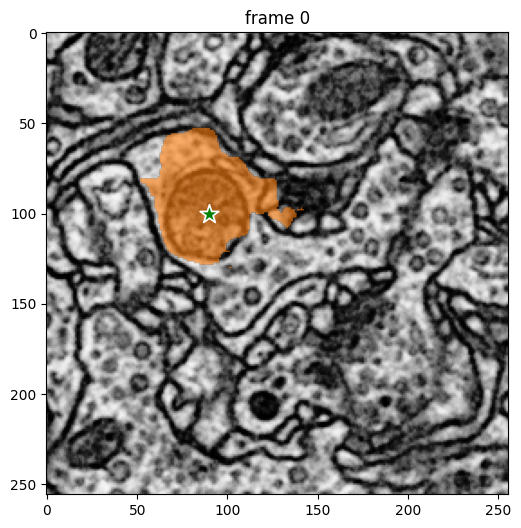

In [145]:
# show the results on the current (interacted) frame
plt.figure(figsize=(9, 6))
plt.title(f"frame {frame_idx}")
plt.imshow(ex_image_1)
show_points(point, label, plt.gca())
show_mask((out_mask_logits[0] > 0.0).cpu().numpy(), plt.gca(), obj_id=out_obj_ids[0])

In [107]:
model_cfg_ft_img = 'configs/sam2/sam2_hiera_s.yaml'
image_predictor = SAM2ImagePredictor(build_sam2(model_cfg_ft_img, sam2_ft_checkpoint, device=device, apply_postprocessing=False))

In [108]:
ex_image_1 = ex_video_1[frame_idx][:,:,np.newaxis]
ex_image_1 = np.repeat(ex_image_1, 3, axis=2)

image_predictor.set_image(ex_image_1.astype(np.float16))
masks, scores, logits = image_predictor.predict(
    point_coords=point,
    point_labels=label,
    multimask_output=True,
)

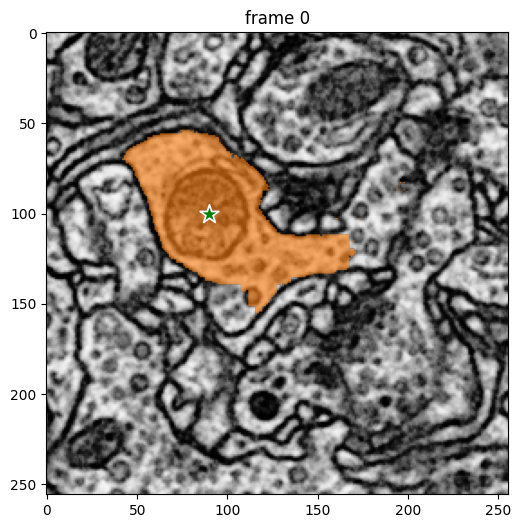

In [109]:
# show the results on the current (interacted) frame
plt.figure(figsize=(9, 6))
plt.title(f"frame {frame_idx}")
plt.imshow(ex_image_1)
show_points(point, label, plt.gca())
show_mask(masks[0], plt.gca(), obj_id=out_obj_ids[0])

In [110]:
video_segments = {}
for out_frame_idx, out_obj_ids, out_mask_logits in video_predictor.propagate_in_video(vi_state):
    video_segments[out_frame_idx] = {
        out_obj_id: (out_mask_logits[i] > 0.0).cpu().numpy()
        for i, out_obj_id in enumerate(out_obj_ids)
    }

propagate in video: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 52.98it/s]


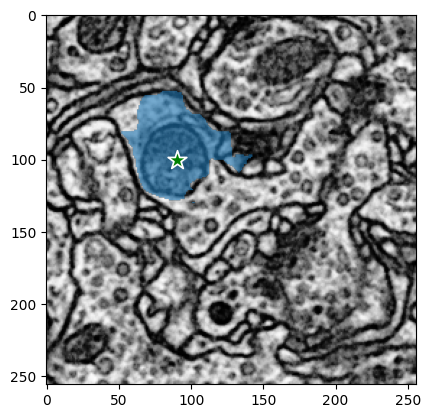

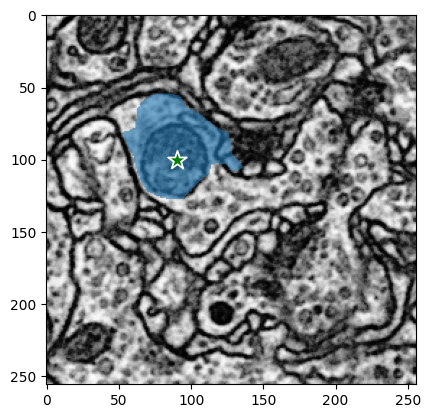

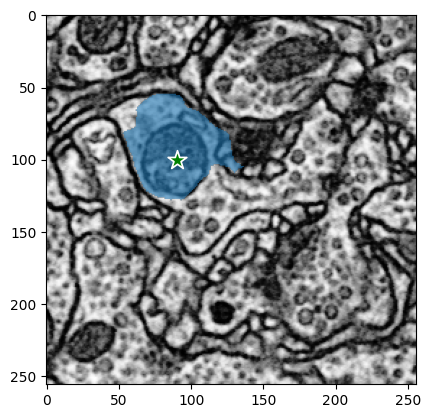

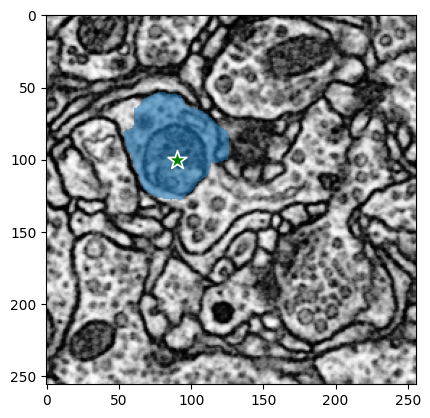

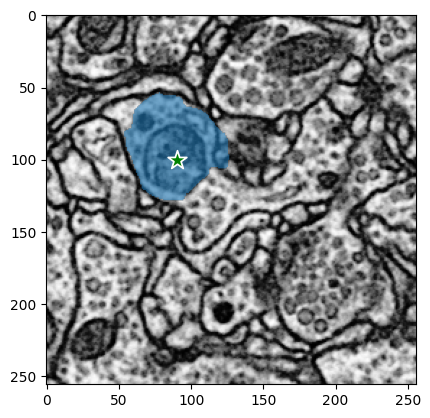

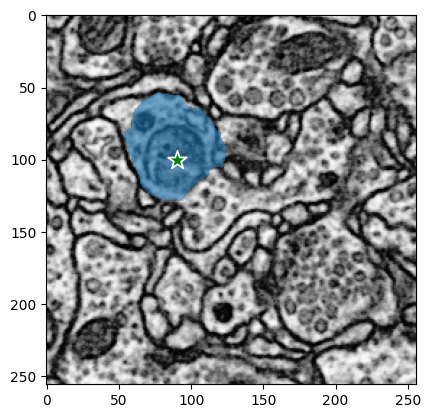

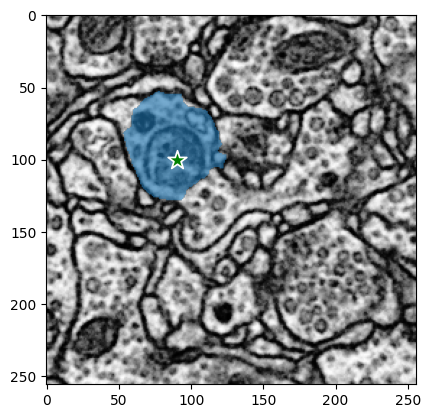

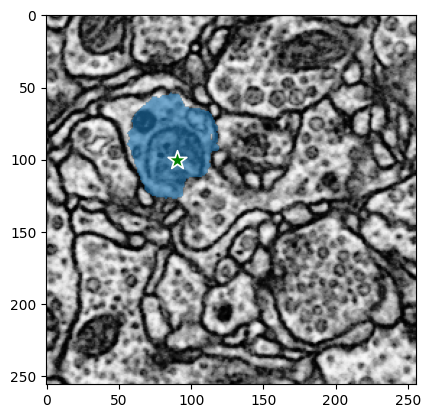

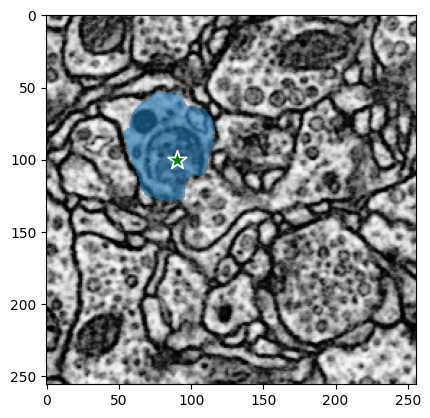

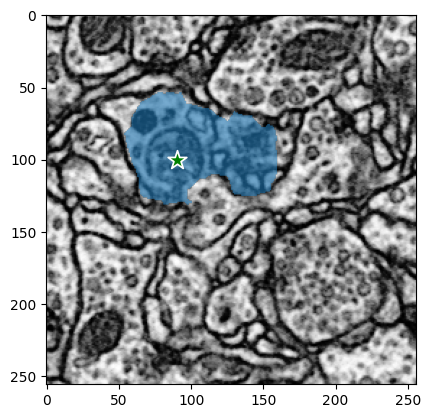

In [120]:
for i, (img, annot, masks) in enumerate(zip(ex_video_1, ex_annot_1, video_segments.values())):
    plt.figure()
    plt.imshow(img, cmap='grey')
    show_mask(masks[obj_id], plt.gca())
    show_points(point, label, plt.gca())

In [ ]:
masks